In [75]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors
from typing import Tuple
import cv2

In [76]:
images = {
    "christmas_tree_6000x4000": "images/christmas_tree_6000x4000.png",
    "christmas_tree_600x400": "images/christmas_tree_600x400.png",
    "lenna_512x512": "images/lenna_512x512.png",
    "lenna_256x256": "images/lenna_256x256.png",
    "lenna_128x128": "images/lenna_128x128.png",
    "lenna_64x64": "images/lenna_64x64.png",
    "lenna_32x32": "images/lenna_32x32.png",
    "Barns_grand_tetons_1600x1195": "images/Barns_grand_tetons_1600x1195.png",
}


In [77]:
# image which should be encoded
image_path = images["lenna_512x512"]

# jpeg parameters
block_size: int = 8
subsampling_settings: Tuple[int, int, int] = (4, 2, 0)
# subsampling_settings: Tuple[int, int, int] = (4, 4, 4)  # can be (4,4,4) (4,4,2)
quantization_table_quality: int = 10  # can be one of: (100, 90, 50, 10)

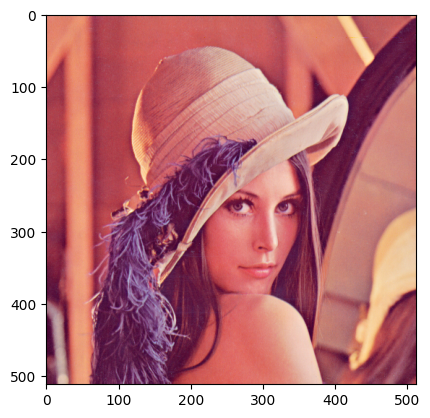

In [78]:
original_image = plt.imread(image_path)
fig, ax = plt.subplots()
ax.imshow(original_image, cmap="gray")

In [79]:
def plot_y_u_v(y_loc, u_loc, v_loc, colormap=True):
    fig_loc, ax_loc = plt.subplots(1, 3, figsize=(15, 20))
    ax_loc[0].imshow(y_loc, cmap="gray")
    ax_loc[0].set_title("Y Component")

    # creating a linear colormap, based on the values of the example https://commons.wikimedia.org/wiki/File:Barn-yuv.png
    if colormap:
        cmap_u = matplotlib.colors.LinearSegmentedColormap.from_list("", [(0, 177 / 255, 78 / 255, 1),
                                                                          (0, 86 / 255, 169 / 255, 1)])
    else:
        cmap_u = matplotlib.colormaps["gray"]
    ax_loc[1].imshow(u_loc, cmap=cmap_u)
    ax_loc[1].set_title("U Component")

    if colormap:
        cmap_v = matplotlib.colors.LinearSegmentedColormap.from_list("", [(104 / 255, 151 / 255, 0, 1),
                                                                          (171 / 255, 84 / 255, 0)])
    else:
        cmap_v = matplotlib.colormaps["gray"]
    ax_loc[2].imshow(v_loc, cmap=cmap_v)
    ax_loc[2].set_title("V Component")
    plt.show()

In [80]:
def get_matrix(size=8):
    matr = []
    for i in range(size):
        matr.append(np.array(range(i * size, (i + 1) * size)))
    matr = np.array(matr)
    print(matr)

## Step 1 
### Colorspace Transformation

In [81]:
from jpeg_implementation.rgbToYuv import rgb_to_yuv

In [82]:
y, u, v = rgb_to_yuv(image=original_image)

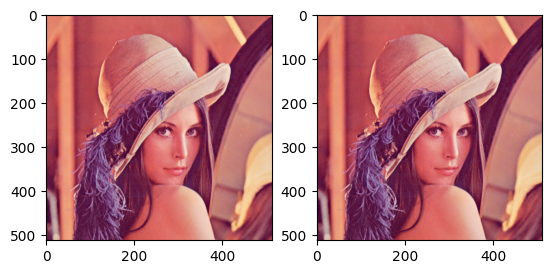

In [83]:
# def yuv_to_rgb2(y, u, v):
#     yuv = cv2.merge((y, u, v))
#     yuv = np.float32(yuv)
#     yuv /= 255
#     image = cv2.cvtColor(yuv, cv2.COLOR_YUV2RGB)
#     return image * 255
#
from jpeg_implementation.rgbToYuv import yuv_to_rgb

image2 = yuv_to_rgb(y,u,v)
fig, ax = plt.subplots(1,2)
ax[0].imshow(original_image)
ax[1].imshow(image2/255)

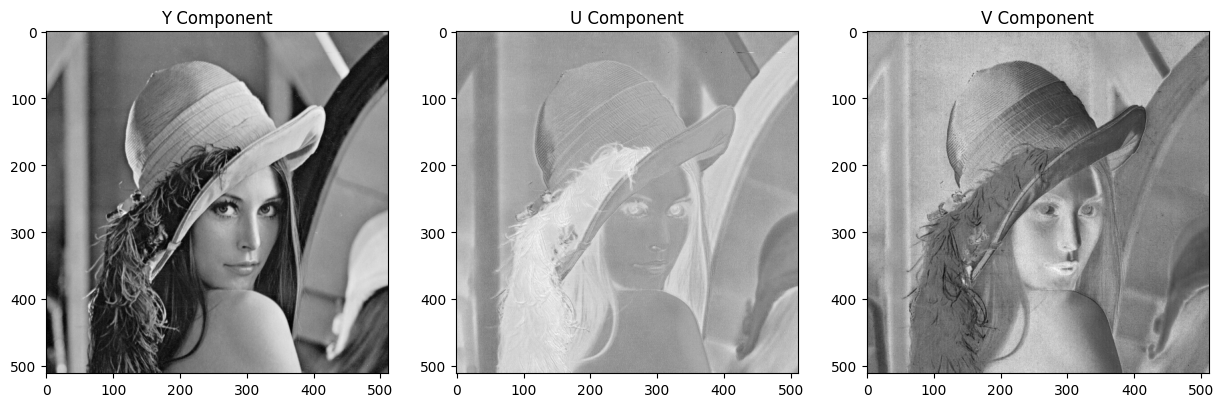

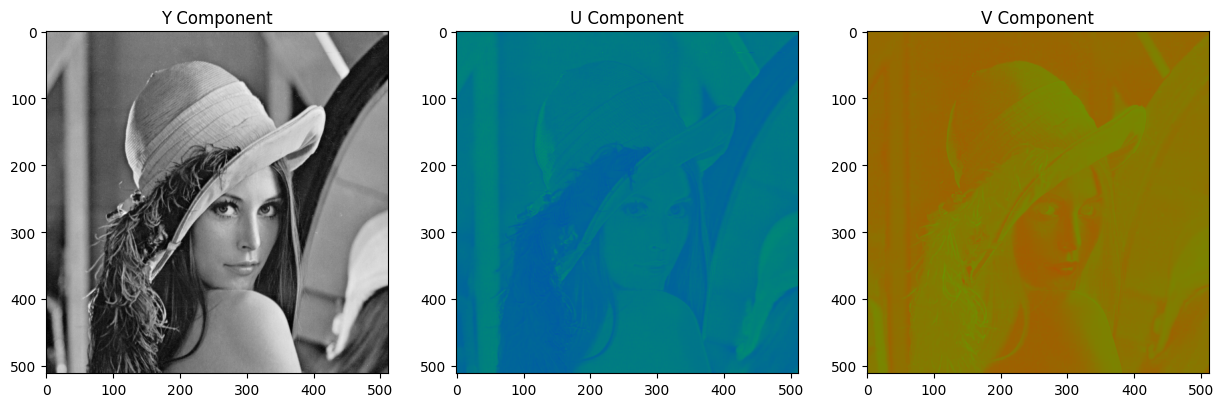

In [84]:
plot_y_u_v(y, u, v, colormap=False)
plot_y_u_v(y, u, v)


## Step 2 
### Subsampling of Color Components

In [85]:
from jpeg_implementation.subsample import subsample_u_v

In [86]:
u_subs, v_subs = subsample_u_v(u, v, *subsampling_settings)
print(len(y), len(u_subs), len(v_subs))

512 256 256


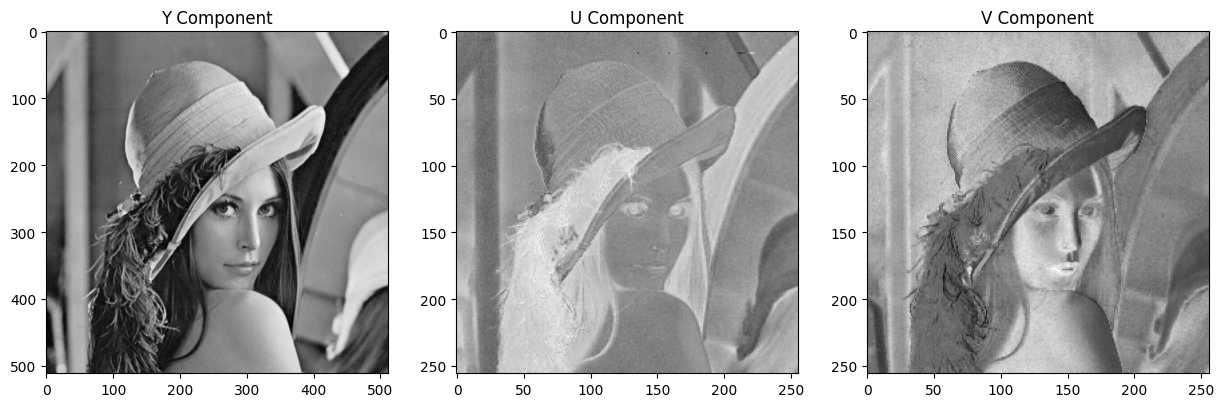

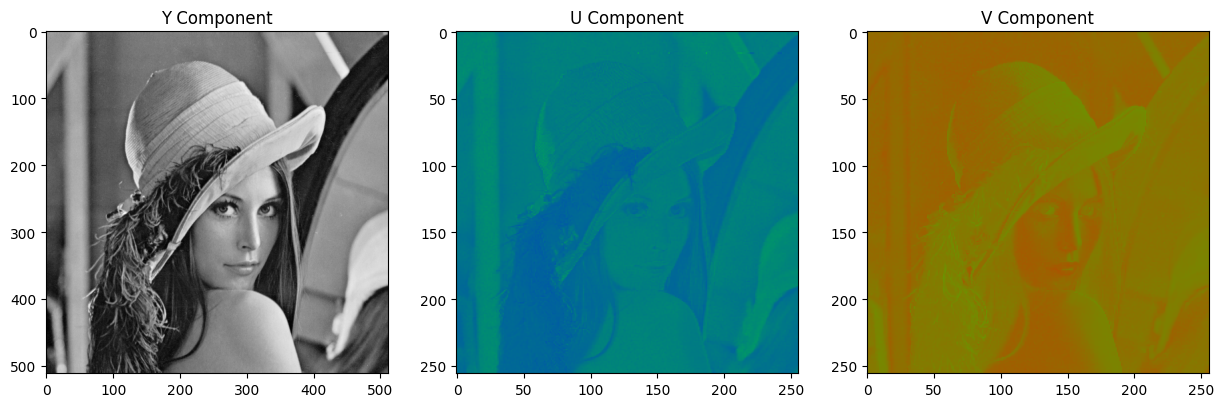

In [87]:
plot_y_u_v(y, u_subs, v_subs, colormap=False)
plot_y_u_v(y, u_subs, v_subs)


## Step 3
### Split into 8x8 Blocks

In [88]:
from jpeg_implementation.splitBlocks import split

In [89]:
split_y = split(y, block_size)
split_u = split(u_subs, block_size)
split_v = split(v_subs, block_size)

print(len(split_y), len(split_u), len(split_v))


4096 1024 1024


[[162.24301 162.24301 162.25801 161.101   162.26001 156.521   163.20001
  160.667  ]
 [162.24301 162.24301 162.25801 161.101   162.26001 156.521   163.20001
  160.667  ]
 [162.24301 162.24301 162.25801 161.101   162.26001 156.521   163.20001
  160.667  ]
 [162.24301 162.24301 162.25801 161.101   162.26001 156.521   163.20001
  160.667  ]
 [162.24301 162.24301 162.25801 161.101   162.26001 156.521   163.20001
  160.667  ]
 [164.07501 164.07501 157.65201 155.342   161.086   159.35301 158.738
  159.723  ]
 [160.39601 160.39601 163.266   158.15701 160.183   161.658   159.179
  155.57701]
 [158.542   158.542   155.381   156.559   158.45001 158.57    156.065
  157.153  ]]


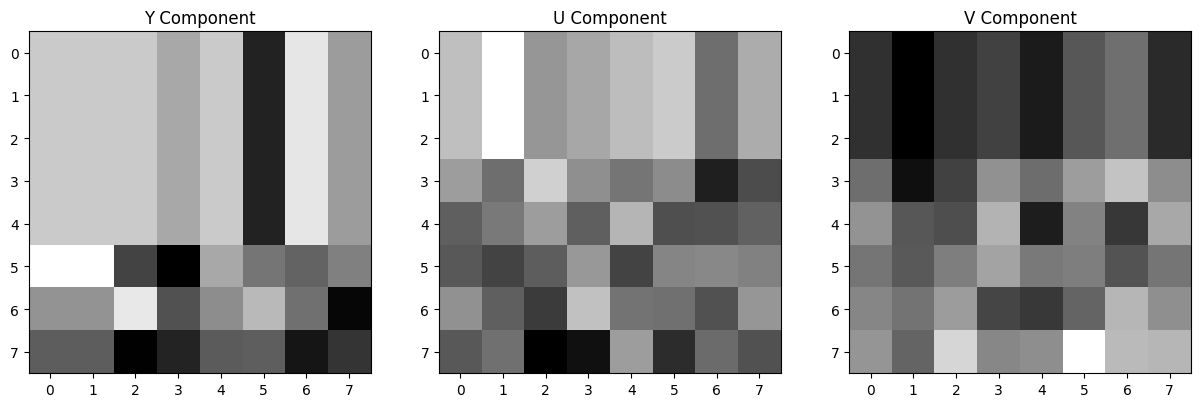

In [90]:
print(split_y[0])
plot_y_u_v(split_y[0], split_u[0], split_v[0], colormap=False)


## Step 3
### Apply dct

In [91]:
from jpeg_implementation.dct import block_dct2

In [92]:
trans_y = block_dct2(np.array(split_y) - 128, block_size)
trans_u = block_dct2(np.array(split_u) - 128, block_size)
trans_v = block_dct2(np.array(split_v) - 128, block_size)


## Step 4 
### Quantization


In [93]:
from jpeg_implementation.quantization import quantize, quantization_tables

quantization_table = quantization_tables[quantization_table_quality]

quantized_y = quantize(trans_y, quantization_table)
quantized_u = quantize(trans_u, quantization_table)
quantized_v = quantize(trans_v, quantization_table)

## Step 5
### Reordering of values, Run Length Encoding

In [94]:
from jpeg_implementation.runLengthEncode import resort_and_run_length_encode

In [95]:
rl_encoded_y = resort_and_run_length_encode(quantized_y, block_size)
rl_encoded_u = resort_and_run_length_encode(quantized_u, block_size)
rl_encoded_v = resort_and_run_length_encode(quantized_v, block_size)


In [96]:
print(len(rl_encoded_y), len(rl_encoded_u), len(rl_encoded_v))
print(rl_encoded_u[0])
print(rl_encoded_v[0])

31846 4500 5602
-2.0
6.0


## Step 6
### Huffman Encoding

In [97]:
from jpeg_implementation.huffman import generate_huffman_code, encode_huffman

data = rl_encoded_y + rl_encoded_u + rl_encoded_v
huffman_code = generate_huffman_code(data)
encoded = encode_huffman(huffman_code, data)
print("original", len(data * 8), "bits")
print("encoded", len(encoded), "bits")
print("encoded + table", len(encoded) + len(huffman_code) * 16, "bits")
print("compression ratio", len(data * 8) / len(encoded))

original 335584 bits
encoded 137131 bits
encoded + table 138523 bits
compression ratio 2.4471782456191526


In [98]:
huffman_code_y = generate_huffman_code(rl_encoded_y)
huff_encoded_y = encode_huffman(huffman_code_y, rl_encoded_y)

huffman_code_u = generate_huffman_code(rl_encoded_u)
huff_encoded_u = encode_huffman(huffman_code_u, rl_encoded_u)

huffman_code_v = generate_huffman_code(rl_encoded_v)
huff_encoded_v = encode_huffman(huffman_code_v, rl_encoded_v)

print("y", len(huff_encoded_y), "bits")
print("u", len(huff_encoded_u), "bits")
print("v", len(huff_encoded_v), "bits")
print("encoded", len(huff_encoded_y) + len(huff_encoded_u) + len(huff_encoded_v), "bits")
print("compression ratio", len(data * 8) / (len(huff_encoded_y) + len(huff_encoded_u) + len(huff_encoded_v)))

y 104256 bits
u 12539 bits
v 16804 bits
encoded 133599 bits
compression ratio 2.511875088885396


## Step 7
### Serialization

In [99]:
from jpeg_implementation.serialize import store_as_file

file_size = store_as_file("test.data", huffman_code_y, huffman_code_u, huffman_code_v, huff_encoded_y, huff_encoded_u,
                          huff_encoded_v)
print(file_size)
print(len(data) / file_size)

17852
2.349764732242886


In [100]:
# calculate effective compression ratio
import os

original_size = os.path.getsize(image_path)
compression_ratio = original_size / file_size
print("Effective Compression Ratio:", compression_ratio, "(Compared to PNG file)")

Effective Compression Ratio: 26.54218014788259 (Compared to PNG file)


## Step 8
### Deserialization

In [101]:
from jpeg_implementation.serialize import read_from_file

huffman_code_y, huffman_code_u, huffman_code_v, huff_encoded_y, huff_encoded_u, huff_encoded_v = read_from_file(
    "test.data")


## Step 9
### Decode Huffman

In [102]:
from jpeg_implementation.huffman import decode_huffman

rl_encoded_y = decode_huffman(huff_encoded_y, huffman_code_y)
rl_encoded_u = decode_huffman(huff_encoded_u, huffman_code_u)
rl_encoded_v = decode_huffman(huff_encoded_v, huffman_code_v)



## Step 10
### Decode run-length encoding + Reordering of values

In [103]:
from jpeg_implementation.runLengthEncode import unsort_and_run_length_decode

y_blocks = unsort_and_run_length_decode(rl_encoded_y, block_size)
u_blocks = unsort_and_run_length_decode(rl_encoded_u, block_size)
v_blocks = unsort_and_run_length_decode(rl_encoded_v, block_size)


## Step 11
### Apply inverse DCT

(1024, 8, 8)


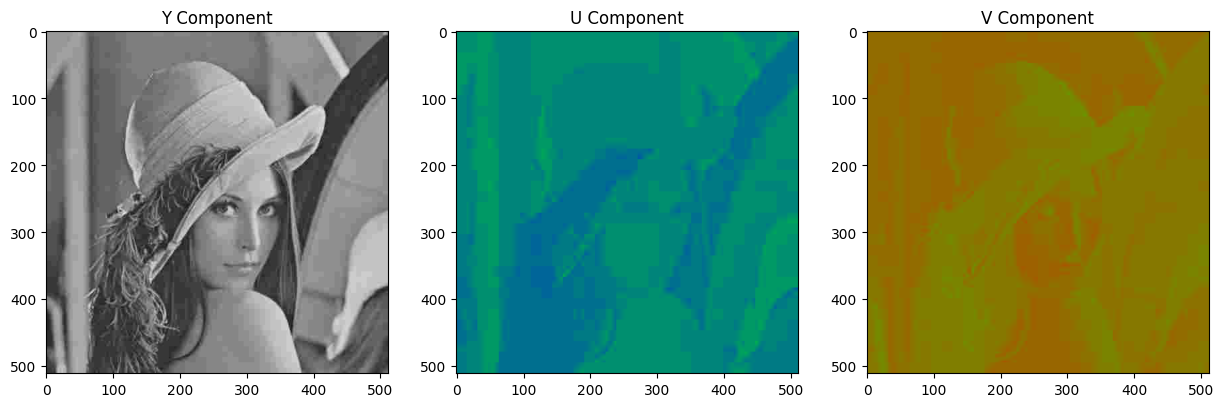

In [104]:
from jpeg_implementation.quantization import quantize_inverse
from jpeg_implementation.dct import block_idct2
from jpeg_implementation.splitBlocks import merge_blocks
from jpeg_implementation.subsample import up_sample_u_v

iq_y = quantize_inverse(y_blocks, quantization_table)
iq_u = quantize_inverse(u_blocks, quantization_table)
iq_v = quantize_inverse(v_blocks, quantization_table)

id_y = block_idct2(iq_y, block_size) + 128
id_u = block_idct2(iq_u, block_size) + 128
id_v = block_idct2(iq_v, block_size) + 128

print(id_u.shape)

compressed_y = merge_blocks(id_y, (512, 512), 8)
compressed_u = merge_blocks(id_u, (256, 256), 8)
compressed_v = merge_blocks(id_v, (256, 256), 8)


compressed_u, compressed_v = up_sample_u_v(compressed_u,compressed_v, *subsampling_settings)

plot_y_u_v(compressed_y,compressed_u,compressed_v)



In [105]:
print(np.max(compressed_y))
print(np.max(compressed_u))
print(np.max(compressed_v))

print(np.min(compressed_y))
print(np.min(compressed_u))
print(np.min(compressed_v))

print(np.max(y))
print(np.max(u))
print(np.max(v))

print(np.min(y))
print(np.min(u))
print(np.min(v))


274.8274770255665
162.83189533375077
230.51936687104256
-14.583332227188833
75.46618719918212
116.34379278887741
245.02101
156.467
222.92023
24.890999
39.500874
118.652824


-32 316


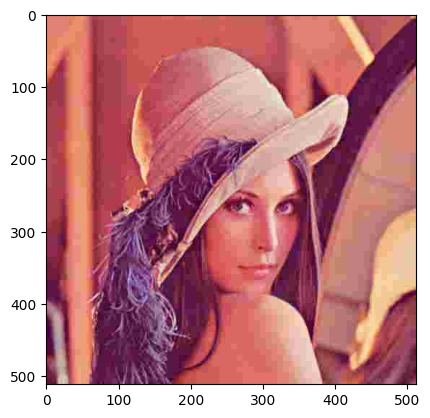

In [121]:
from jpeg_implementation.rgbToYuv import yuv_to_rgb

reconstructed_image = yuv_to_rgb(compressed_y,compressed_u, compressed_v)

print(np.min(reconstructed_image), np.max(reconstructed_image))

reconstructed_image = reconstructed_image.astype(int)
reconstructed_image = reconstructed_image.clip(0,255)

fig, ax = plt.subplots()
ax.imshow(reconstructed_image)
plt.savefig("compressed.png")
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(512, 512, 3)
0.01568627543747425 315.07843136787415


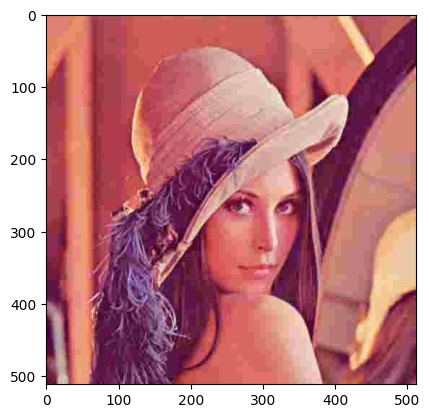

In [107]:
# print(image.shape)
# print(reconstructed_image.shape)
res = np.dstack([reconstructed_image, np.zeros(512**2).reshape(512,512)])

diff = np.abs(original_image - reconstructed_image)

print(diff.shape)
fig, ax = plt.subplots()

print(np.min(diff), np.max(diff))

ax.imshow(diff/255)
plt.show()